In [1]:
from google.colab import files
uploaded = files.upload()


Saving SEP28k.zip to SEP28k.zip


In [2]:
import os
from zipfile import ZipFile

# Get uploaded filename
zip_filename = list(uploaded.keys())[0]
extract_path = "audio_data"

with ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Files extracted to:", extract_path)


✅ Files extracted to: audio_data


In [3]:
# Walk through the unzipped folder and list all .wav files
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith(".wav"):
            print(os.path.join(root, file))


audio_data/SEP28k/MyStutteringLife_4_1.wav
audio_data/SEP28k/MyStutteringLife_5_10.wav
audio_data/SEP28k/MyStutteringLife_1_7.wav
audio_data/SEP28k/HeStutters_1_63.wav
audio_data/SEP28k/MyStutteringLife_7_48.wav
audio_data/SEP28k/MyStutteringLife_4_31.wav
audio_data/SEP28k/MyStutteringLife_7_77.wav
audio_data/SEP28k/HeStutters_1_13.wav
audio_data/SEP28k/MyStutteringLife_7_86.wav
audio_data/SEP28k/HeStutters_1_14.wav
audio_data/SEP28k/HeStutters_1_93.wav
audio_data/SEP28k/HeStutters_1_35.wav
audio_data/SEP28k/HeStutters_1_43.wav
audio_data/SEP28k/MyStutteringLife_3_31.wav
audio_data/SEP28k/HeStutters_1_50.wav
audio_data/SEP28k/MyStutteringLife_7_58.wav
audio_data/SEP28k/MyStutteringLife_6_37.wav
audio_data/SEP28k/MyStutteringLife_7_32.wav
audio_data/SEP28k/MyStutteringLife_6_33.wav
audio_data/SEP28k/MyStutteringLife_2_30.wav
audio_data/SEP28k/MyStutteringLife_6_17.wav
audio_data/SEP28k/MyStutteringLife_6_9.wav
audio_data/SEP28k/MyStutteringLife_7_0.wav
audio_data/SEP28k/MyStutteringLife

In [4]:
import os

DATA_DIR = "audio_data/SEP28k"

normal_count = 1
stuttered_count = 1

for filename in os.listdir(DATA_DIR):
    if filename.endswith(".wav"):
        if "MyStutteringLife" in filename:
            new_name = f"normal_{normal_count:03d}.wav"
            normal_count += 1
        elif "HeStutters" in filename:
            new_name = f"stuttered_{stuttered_count:03d}.wav"
            stuttered_count += 1
        else:
            # Skip files that don't match either pattern
            continue

        src = os.path.join(DATA_DIR, filename)
        dst = os.path.join(DATA_DIR, new_name)
        os.rename(src, dst)

print("✅ Renaming completed!")


✅ Renaming completed!


In [5]:
import librosa
import numpy as np
import os

DATA_DIR = "audio_data/SEP28k"

def extract_features(file_path, max_pad_len=200):
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    return mfccs

X = []
y = []

for filename in os.listdir(DATA_DIR):
    if filename.endswith(".wav"):
        label = 1 if filename.startswith("stuttered") else 0
        features = extract_features(os.path.join(DATA_DIR, filename))
        X.append(features)
        y.append(label)

X = np.array(X)
y = np.array(y)

print(f"✅ Extracted MFCC features for {len(X)} files")
print(f"Feature array shape: {X.shape}")
print(f"Labels shape: {y.shape}")


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning:

✅ Extracted MFCC features for 522 files
Feature array shape: (522, 40, 200)
Labels shape: (522,)


In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Reshape X: from (samples, features, time) → (samples, time, features)
X = X.transpose(0, 2, 1)  # shape becomes (522, 200, 40)

# One-hot encode labels
y_cat = to_categorical(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

# Define model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 198, 64)        │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 99, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,914 (167.63 KB)

 Trainable params: 42,914 (167.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7344 - loss: 0.6000 - val_accuracy: 0.7333 - val_loss: 0.4587
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7991 - loss: 0.4043 - val_accuracy: 0.9238 - val_loss: 0.3722
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9403 - loss: 0.3622 - val_accuracy: 0.9238 - val_loss: 0.2796
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9614 - loss: 0.1787 - val_accuracy: 0.9238 - val_loss: 0.2568
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9572 - loss: 0.1965 - val_accuracy: 0.9238 - val_loss: 0.2553
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9434 - loss: 0.1939 - val_accuracy: 0.9238 - val_loss: 0.2614
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9627 - loss: 0.1658 - val_accuracy: 0.9238 - val_loss: 0.2544
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9449 - loss: 0.1916 - val_accuracy: 0.9238 - v

In [8]:
from google.colab import files
import numpy as np

def extract_features(file_path, max_pad_len=200):
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    return mfccs

def predict_audio(file_path):
    features = extract_features(file_path)
    features = features.T.reshape(1, features.shape[1], features.shape[0])  # reshape to (1, 200, 40)
    pred = model.predict(features)
    class_idx = np.argmax(pred)
    classes = ["Normal Voice", "Stuttered Voice"]
    return classes[class_idx]

# Upload new audio file
uploaded = files.upload()
for file in uploaded.keys():
    result = predict_audio(file)
    print(f"Prediction for '{file}': {result}")


Saving HeStutters_0_4.wav to HeStutters_0_4.wav


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Prediction for 'HeStutters_0_4.wav': Stuttered Voice


In [9]:
import numpy as np

# Get predicted probabilities and classes on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [10]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=["Normal", "Stuttered"])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

      Normal       0.91      1.00      0.95        77
   Stuttered       1.00      0.71      0.83        28

    accuracy                           0.92       105
   macro avg       0.95      0.86      0.89       105
weighted avg       0.93      0.92      0.92       105



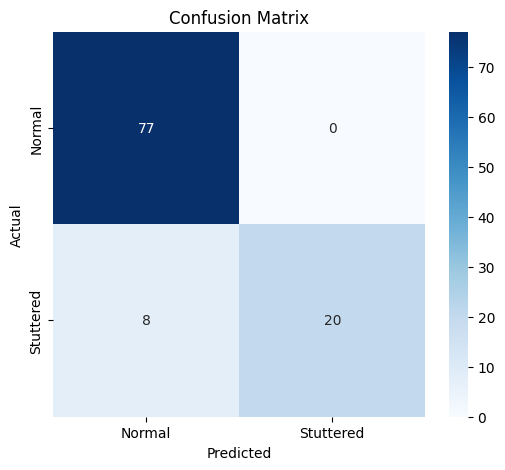

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Stuttered"], yticklabels=["Normal", "Stuttered"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


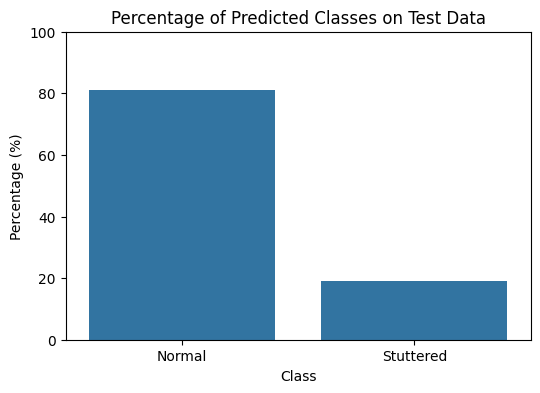

In [12]:
import pandas as pd

unique, counts = np.unique(y_pred, return_counts=True)
percentages = counts / counts.sum() * 100

df = pd.DataFrame({'Class': ["Normal", "Stuttered"], 'Percentage': percentages})

plt.figure(figsize=(6,4))
sns.barplot(x='Class', y='Percentage', data=df)
plt.title('Percentage of Predicted Classes on Test Data')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.show()


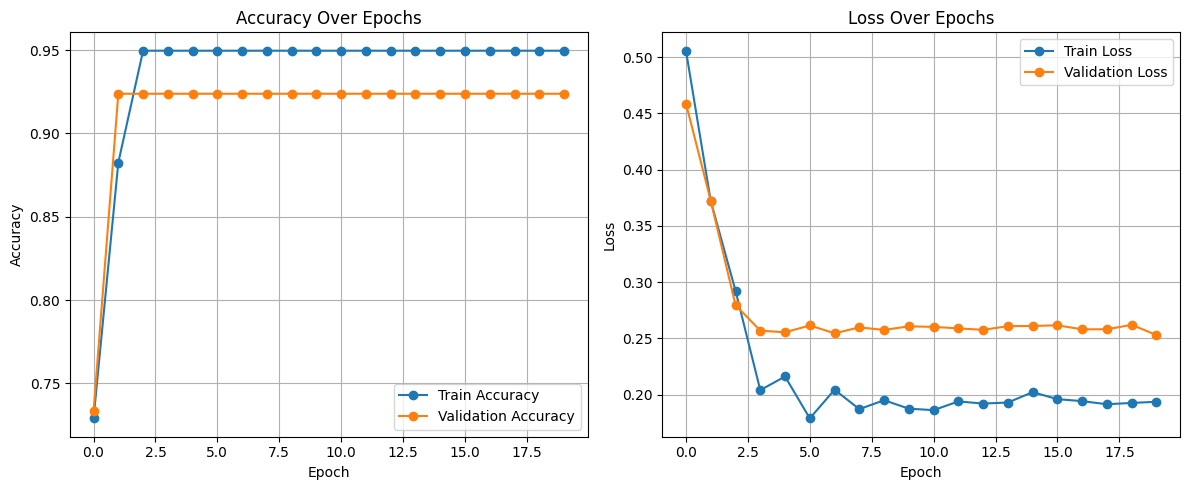

In [13]:
import matplotlib.pyplot as plt

# Plot accuracy curves
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Saving uh-uh-uh-uh-93959.mp3 to uh-uh-uh-uh-93959.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


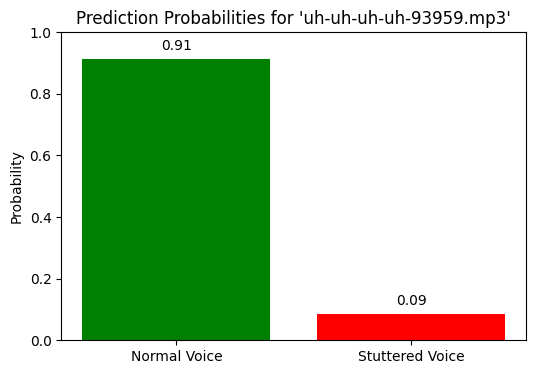

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction_probabilities(file_path):
    features = extract_features(file_path)
    features = features.T.reshape(1, features.shape[1], features.shape[0])
    pred_probs = model.predict(features)[0]

    classes = ["Normal Voice", "Stuttered Voice"]

    plt.figure(figsize=(6,4))
    bars = plt.bar(classes, pred_probs, color=['green', 'red'])
    plt.title(f"Prediction Probabilities for '{file_path}'")
    plt.ylabel('Probability')
    plt.ylim([0,1])

    # Show values on bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

    plt.show()

# Example usage:
from google.colab import files
uploaded = files.upload()

for file in uploaded.keys():
    plot_prediction_probabilities(file)
